In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
training_dataset = read_csv("segment_speeds_weather_road_events_training_data.csv", sep=",")

values = training_dataset.values

In [3]:
training_dataset.head(4)

,Unnamed: 0,SegmentId,StartTime,hour,day,year,Speed,Monday,Saturday,Sunday,...,Friday,holiday,Lufttemperatur,EVENT_TEXT,Nederbördsmängd,Vindhastighet,Snödjup,Temperature-with-last-known-value-on-nan,Wind-speed-avg-when-nan,EVENT_CODE_35.0
0,0,428389808,2019-06-04 00:00:00,0,155,2019,116.150000,0,0,0,...,0,0,13.7,0,0.0,4.7,0.0,13.7,4.7,0
1,1,428389808,2019-06-04 01:00:00,1,155,2019,94.033333,0,0,0,...,0,0,14.1,0,0.0,5.0,0.0,14.1,5.0,0
2,2,428389808,2019-06-04 02:00:00,2,155,2019,93.983333,0,0,0,...,0,0,14.2,0,0.0,4.8,0.0,14.2,4.8,0
3,3,428389808,2019-06-04 03:00:00,3,155,2019,83.466667,0,0,0,...,0,0,14.3,0,0.0,4.9,0.0,14.3,4.9,0


In [6]:
training_dataset.drop(columns  = ['StartTime','EVENT_TEXT'], inplace = True)
values = training_dataset.values
# ensure all data is float
values = values.astype('float32')

In [4]:
test_dataset = read_csv("segment_speeds_weather_road_events_training_data.csv", sep=",")

values = test_dataset.values

In [5]:
test_dataset.drop(columns  = ['StartTime','EVENT_TEXT'], inplace = True)
values = test_dataset.values
# ensure all data is float
values = values.astype('float32')

In [7]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)
scaled.head(4)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.000000,0.0,0.000000,0.421918,0.0,0.857726,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.622222,0.0,0.237374,0.0,0.622222,0.237374,0.0
1,0.000046,0.0,0.043478,0.421918,0.0,0.683074,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.633333,0.0,0.252525,0.0,0.633333,0.252525,0.0
2,0.000093,0.0,0.086957,0.421918,0.0,0.682680,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.636111,0.0,0.242424,0.0,0.636111,0.242424,0.0
3,0.000139,0.0,0.130435,0.421918,0.0,0.599631,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.638889,0.0,0.247475,0.0,0.638889,0.247475,0.0


In [10]:
def create_ts_data(training_dataset, lookback=1, predicted_col=6):
    temp=training_dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=training_dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [13]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,1)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)','var21(t-1)', 'var1(t)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1    0.000000        0.0   0.000000   0.421918        0.0   0.857726   
2    0.000046        0.0   0.043478   0.421918        0.0   0.683074   
3    0.000093        0.0   0.086957   0.421918        0.0   0.682680   
4    0.000139        0.0   0.130435   0.421918        0.0   0.599631   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var13(t-1)  var14(t-1)  \
id                                               ...                           
1         0.0        0.0        0.0         0.0  ...         0.0         0.0   
2         0.0        0.0        0.0         0.0  ...         0.0         0.0   
3         0.0        0.0        0.0         0.0  ...         0.0         0.0   
4         0.0        0.0        0.0         0.0  ...         0.0         0.0   

    var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  var19(t-1)  var20(t-1)  \
id      

In [14]:
values = reframed_df.values
training_sample =int(len(training_dataset))
test_sample =int(len(test_dataset))
train = values[:training_sample, :]
test = values[:test_sample, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [15]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21540, 1, 21) (21540,) (21540, 1, 21) (21540,)


In [16]:
model_lstm = Sequential()
model_lstm.add(LSTM(512, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=80, return_sequences=True))
model_lstm.add(LSTM(units=80))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 512)            1093632   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 80)             189760    
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 1,334,993
Trainable params: 1,334,993
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=50, shuffle=False)

Epoch 1/30
431/431 [==============================] - 20s 13ms/step - loss: 8.2407e-04 - val_loss: 5.3569e-04
Epoch 2/30
431/431 [==============================] - 4s 10ms/step - loss: 1.7716e-04 - val_loss: 6.8524e-05
Epoch 3/30
431/431 [==============================] - 5s 11ms/step - loss: 1.2742e-04 - val_loss: 7.7385e-05
Epoch 4/30
431/431 [==============================] - 4s 10ms/step - loss: 8.1088e-05 - val_loss: 7.2039e-05
Epoch 5/30
431/431 [==============================] - 4s 10ms/step - loss: 5.9100e-05 - val_loss: 7.2712e-05
Epoch 6/30
431/431 [==============================] - 4s 10ms/step - loss: 6.7139e-05 - val_loss: 9.9275e-05
Epoch 7/30
431/431 [==============================] - 5s 11ms/step - loss: 9.7769e-05 - val_loss: 9.7379e-05
Epoch 8/30
431/431 [==============================] - 4s 10ms/step - loss: 9.8680e-05 - val_loss: 6.3908e-05
Epoch 9/30
431/431 [==============================] - 4s 10ms/step - loss: 9.7201e-05 - val_loss: 1.2484e-04
Epoch 10/30
431/43

In [18]:
pred_y =  model_lstm.predict(test_X)

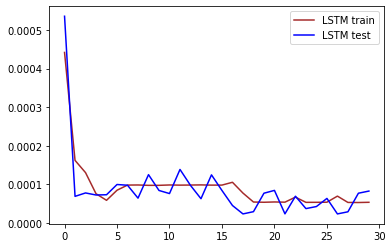

In [19]:
pyplot.plot(lstm_history.history['loss'], label='LSTM train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='LSTM test', color='blue')
pyplot.legend()
pyplot.show()

In [21]:
test_y.reshape(21540,1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [22]:
pred_y

array([[8.2228005e-05],
       [8.2134720e-05],
       [8.2170794e-05],
       ...,
       [8.1956794e-05],
       [8.1906837e-05],
       [8.1361053e-05]], dtype=float32)

6.764978e-09
0.0
8.224948578069596e-05
8.2248655e-05


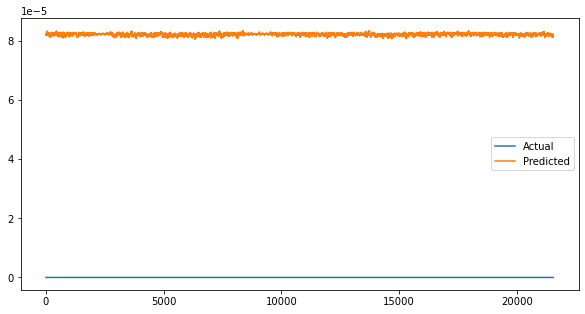

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

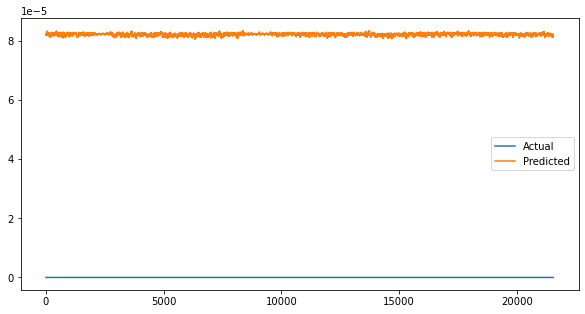

In [24]:
#visualization over full data
tra = test_X
tes = test_y
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()